In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
data = pd.read_csv("smoke_detection_iot.csv")

In [41]:
data.head(2)

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0


In [42]:
data.drop(['Unnamed: 0','UTC'],axis=1,inplace=True)

In [43]:
data.head(2)

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0


In [44]:
X = data.drop('Fire Alarm',axis=1).values
Y = data['Fire Alarm'].values

In [45]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8)

In [46]:
X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T

In [48]:
X_train.shape

(13, 50104)

In [49]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s , z

In [50]:
def relu(z):
    A = np.maximum(0,z)
    return A , z

In [51]:
def relu_backward(dA,cache):
    
    z = cache
    dz = np.array(dA,copy=True)
    
    dz[z <= 0] =0
    return dz

In [52]:
def sigmoid_backward(dA,cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [53]:
def initialize_weight_deep(layers_dim):  #list of nuron in every layers
    
    np.random.seed(3)
    L = len(layers_dim)
    
    parameters = {}
    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1]) *0.01
        parameters['b'+str(l)] = np.zeros((layers_dim[l],1))
    
    return parameters   


In [54]:
def linear_propagate(A,W,b):
    
    Z = np.dot(W,A) + b
    cache = (A,W,b)
    
    return Z , cache


In [55]:
def Linear_propagate_activation(A_prev,W,b,activation):
    
    if activation == 'sigmoid':
        Z , linear_cache = linear_propagate(A_prev,W,b)
        A , activation_cache = sigmoid(Z)
        
    else:
        Z , linear_cache = linear_propagate(A_prev,W,b)
        A , activation_cache = relu(Z)
    cache = (linear_cache,activation_cache)
    return A,cache

In [56]:
def L_Layer_forward(X , parameters):
    
    A = X
    caches = []
    L = len(parameters)//2
    for l in range(1,L):
        A_prev = A
        
        A , cache = Linear_propagate_activation(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
    
    AL , cache = Linear_propagate_activation(A,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    caches.append(cache)
    
    return AL, caches


In [57]:
def cost_function(AL,Y):
    m = AL.shape[1]
    
    cost = np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),(1-Y))
    
    cost = -1/m*np.sum(cost)
    
    return cost


In [58]:
def linear_backward(dz , cache):
    A_prev , W , b = cache
    
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dz,A_prev.T)
    db = 1/m * np.sum(dz,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dz)
    
    return dA_prev , dW ,db

In [59]:
def linear_backward_activation(dA , cache,activation):
    linear_cache,activation_cache = cache
    
    if activation == 'sigmoid':
        dz = sigmoid_backward(dA,activation_cache)
        dA_prev , dW ,db = linear_backward(dz,linear_cache)
        
    elif activation == 'relu':
        dz = relu_backward(dA,activation_cache)
        dA_prev , dW ,db = linear_backward(dz,linear_cache)
    return dA_prev , dW , db    

In [60]:
def L_layer_backward(AL, Y , caches):
    
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = -(np.divide(Y,AL) - np.divide((1-Y),(1-AL)))
    
   
    dA_prev_temp, dW_temp, db_temp = linear_backward_activation(dAL,caches[L-1], 'sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
   
    for l in reversed(range(L-1)):
        dA_prev_temp, dW_temp, db_temp =  linear_backward_activation(grads['dA'+str(l+1)], caches[l], 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads


In [61]:
def update_parameters(parameters, grads , lr):
    
    L= len(parameters) // 2
    
    for l in range(1,L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - lr* grads['dW'+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - lr* grads['db'+str(l+1)]
        
    return parameters  


In [62]:
def NN_model(X , Y , lr , layers_dim , epochs):
    
    paras = initialize_weight_deep(layers_dim)
    
    costs =[]
    
    for i in range(epochs):
        AL,cache = L_Layer_forward(X , paras)

        cost = cost_function(AL,Y)
        costs.append(cost)

        grads = L_layer_backward(AL, Y , cache)

        paras = update_parameters(paras, grads , lr)

        print("Epochs : "+str(i)+"| cost : "+str(cost))
        
    return paras , costs        
    

In [64]:
paras ,costs = NN_model(X_train,Y_train,0.0001,[X_train.shape[0],30,3,1],5000)

Epochs : 0| cost : 0.6700696807634081
Epochs : 1| cost : 0.668582825306691
Epochs : 2| cost : 0.6669723316525455
Epochs : 3| cost : 0.6652639145086837
Epochs : 4| cost : 0.6635159228576218
Epochs : 5| cost : 0.6617327052389568
Epochs : 6| cost : 0.6599173054552442
Epochs : 7| cost : 0.6580764881825168
Epochs : 8| cost : 0.656216092217791
Epochs : 9| cost : 0.6543352431051425
Epochs : 10| cost : 0.6524321812243628
Epochs : 11| cost : 0.6504990074609035
Epochs : 12| cost : 0.6485467891478652
Epochs : 13| cost : 0.6465871213507118
Epochs : 14| cost : 0.644585226734409
Epochs : 15| cost : 0.6425277098775986
Epochs : 16| cost : 0.6404150697832991
Epochs : 17| cost : 0.6382482258951595
Epochs : 18| cost : 0.6360282053262981
Epochs : 19| cost : 0.6337562847768895
Epochs : 20| cost : 0.6314340166599427
Epochs : 21| cost : 0.629063301626781
Epochs : 22| cost : 0.6266461796950333
Epochs : 23| cost : 0.6241849519995177
Epochs : 24| cost : 0.62168229124149
Epochs : 25| cost : 0.6191411829239439
Ep

Epochs : 209| cost : 0.4084879660424221
Epochs : 210| cost : 0.4076692842838434
Epochs : 211| cost : 0.40685107935859255
Epochs : 212| cost : 0.40603345099335403
Epochs : 213| cost : 0.40521657994729965
Epochs : 214| cost : 0.40440036598878826
Epochs : 215| cost : 0.4035849783029677
Epochs : 216| cost : 0.402770335336595
Epochs : 217| cost : 0.40195648649493665
Epochs : 218| cost : 0.401143502842214
Epochs : 219| cost : 0.4003317228199987
Epochs : 220| cost : 0.39952095712599145
Epochs : 221| cost : 0.3987112892685241
Epochs : 222| cost : 0.397902802814204
Epochs : 223| cost : 0.39709529536777843
Epochs : 224| cost : 0.39628880939395433
Epochs : 225| cost : 0.39548342729504293
Epochs : 226| cost : 0.39467930770278076
Epochs : 227| cost : 0.3938766559983327
Epochs : 228| cost : 0.39307523799436805
Epochs : 229| cost : 0.3922751910818241
Epochs : 230| cost : 0.39147660292940095
Epochs : 231| cost : 0.3906792861695512
Epochs : 232| cost : 0.38988618099084704
Epochs : 233| cost : 0.3891094

Epochs : 413| cost : 0.30739321101431194
Epochs : 414| cost : 0.30707201752143987
Epochs : 415| cost : 0.30675124312108604
Epochs : 416| cost : 0.3064308716813543
Epochs : 417| cost : 0.30611087056388514
Epochs : 418| cost : 0.30579122757214744
Epochs : 419| cost : 0.30547197510254237
Epochs : 420| cost : 0.30515308311899225
Epochs : 421| cost : 0.30483461917654603
Epochs : 422| cost : 0.3045165319094878
Epochs : 423| cost : 0.30419877324668415
Epochs : 424| cost : 0.3038813734570368
Epochs : 425| cost : 0.3035643016039004
Epochs : 426| cost : 0.3032475494393288
Epochs : 427| cost : 0.3029311075522781
Epochs : 428| cost : 0.30261490985000433
Epochs : 429| cost : 0.30229900353350875
Epochs : 430| cost : 0.30198338479430925
Epochs : 431| cost : 0.3016680598393234
Epochs : 432| cost : 0.30135301262286346
Epochs : 433| cost : 0.3010382120499678
Epochs : 434| cost : 0.3007236877895448
Epochs : 435| cost : 0.3004094571441577
Epochs : 436| cost : 0.3000955177125049
Epochs : 437| cost : 0.2997

Epochs : 619| cost : 0.24700927370831546
Epochs : 620| cost : 0.24676394925359216
Epochs : 621| cost : 0.2465194874469348
Epochs : 622| cost : 0.2462757544753246
Epochs : 623| cost : 0.24603288704386939
Epochs : 624| cost : 0.2457905781252939
Epochs : 625| cost : 0.24554899062189317
Epochs : 626| cost : 0.24530808966710055
Epochs : 627| cost : 0.24506777384077588
Epochs : 628| cost : 0.24482811901012677
Epochs : 629| cost : 0.24458934812625305
Epochs : 630| cost : 0.24435131390143305
Epochs : 631| cost : 0.2441140823572614
Epochs : 632| cost : 0.2438775347951568
Epochs : 633| cost : 0.2436415854838224
Epochs : 634| cost : 0.24340604936641091
Epochs : 635| cost : 0.2431709749358792
Epochs : 636| cost : 0.242936598004213
Epochs : 637| cost : 0.2427029631859701
Epochs : 638| cost : 0.24246997232365883
Epochs : 639| cost : 0.2422372170855851
Epochs : 640| cost : 0.24200486777875033
Epochs : 641| cost : 0.24177282497461838
Epochs : 642| cost : 0.2415409419464023
Epochs : 643| cost : 0.24130

Epochs : 821| cost : 0.2082130079242305
Epochs : 822| cost : 0.20806905894764735
Epochs : 823| cost : 0.2079255475296567
Epochs : 824| cost : 0.20778245883781982
Epochs : 825| cost : 0.20763979427484439
Epochs : 826| cost : 0.2074975509180236
Epochs : 827| cost : 0.20735572014813577
Epochs : 828| cost : 0.20721430819613165
Epochs : 829| cost : 0.20707331177824342
Epochs : 830| cost : 0.20693272099712962
Epochs : 831| cost : 0.20679254121019988
Epochs : 832| cost : 0.2066527790043304
Epochs : 833| cost : 0.20651342395720826
Epochs : 834| cost : 0.2063744827972539
Epochs : 835| cost : 0.20623596982310005
Epochs : 836| cost : 0.2060978669830412
Epochs : 837| cost : 0.20596017110392192
Epochs : 838| cost : 0.20582287821793913
Epochs : 839| cost : 0.2056859842778726
Epochs : 840| cost : 0.20554948467923392
Epochs : 841| cost : 0.20541338325439354
Epochs : 842| cost : 0.205277681443271
Epochs : 843| cost : 0.20514238308475094
Epochs : 844| cost : 0.20500748223373455
Epochs : 845| cost : 0.20

Epochs : 1023| cost : 0.18590920139847833
Epochs : 1024| cost : 0.18582490652909256
Epochs : 1025| cost : 0.1857408105575802
Epochs : 1026| cost : 0.18565691150178537
Epochs : 1027| cost : 0.18557320954449413
Epochs : 1028| cost : 0.18548970779344093
Epochs : 1029| cost : 0.18540640245614243
Epochs : 1030| cost : 0.18532329235816264
Epochs : 1031| cost : 0.18524037925172263
Epochs : 1032| cost : 0.18515765995690847
Epochs : 1033| cost : 0.18507513245044965
Epochs : 1034| cost : 0.1849927975772108
Epochs : 1035| cost : 0.18491065639154433
Epochs : 1036| cost : 0.18482870716020736
Epochs : 1037| cost : 0.1847469475819449
Epochs : 1038| cost : 0.1846653778046017
Epochs : 1039| cost : 0.18458400060975513
Epochs : 1040| cost : 0.18450281835539617
Epochs : 1041| cost : 0.1844218247818604
Epochs : 1042| cost : 0.1843410205827782
Epochs : 1043| cost : 0.18426040523067433
Epochs : 1044| cost : 0.1841799779818812
Epochs : 1045| cost : 0.18409973526344348
Epochs : 1046| cost : 0.18401967774408484

Epochs : 1220| cost : 0.17239854469511182
Epochs : 1221| cost : 0.1723428853978861
Epochs : 1222| cost : 0.1722873329333544
Epochs : 1223| cost : 0.17223188699017766
Epochs : 1224| cost : 0.17217654726117723
Epochs : 1225| cost : 0.17212131344238174
Epochs : 1226| cost : 0.17206618523237024
Epochs : 1227| cost : 0.17201116236364739
Epochs : 1228| cost : 0.171956244804176
Epochs : 1229| cost : 0.17190143196307625
Epochs : 1230| cost : 0.17184672354443617
Epochs : 1231| cost : 0.1717921192540853
Epochs : 1232| cost : 0.17173761879938793
Epochs : 1233| cost : 0.1716832218890993
Epochs : 1234| cost : 0.17162892823326528
Epochs : 1235| cost : 0.17157473754315172
Epochs : 1236| cost : 0.1715206495311937
Epochs : 1237| cost : 0.17146666391095944
Epochs : 1238| cost : 0.17141278039712332
Epochs : 1239| cost : 0.1713589987054461
Epochs : 1240| cost : 0.17130531855275913
Epochs : 1241| cost : 0.17125174100518156
Epochs : 1242| cost : 0.17119826586070483
Epochs : 1243| cost : 0.17114489166539462


Epochs : 1417| cost : 0.1631720051182245
Epochs : 1418| cost : 0.16313271057859602
Epochs : 1419| cost : 0.1630934797946823
Epochs : 1420| cost : 0.1630543126105763
Epochs : 1421| cost : 0.16301520887180979
Epochs : 1422| cost : 0.16297616842504328
Epochs : 1423| cost : 0.16293719111785546
Epochs : 1424| cost : 0.16289827679860028
Epochs : 1425| cost : 0.16285942531630948
Epochs : 1426| cost : 0.16282063671479793
Epochs : 1427| cost : 0.16278191092910083
Epochs : 1428| cost : 0.16274324753034233
Epochs : 1429| cost : 0.16270464637109489
Epochs : 1430| cost : 0.162666107425693
Epochs : 1431| cost : 0.16262763042272338
Epochs : 1432| cost : 0.16258921523085812
Epochs : 1433| cost : 0.16255086179350603
Epochs : 1434| cost : 0.16251256987521112
Epochs : 1435| cost : 0.16247433942063094
Epochs : 1436| cost : 0.16243617025160478
Epochs : 1437| cost : 0.16239806214990266
Epochs : 1438| cost : 0.16236001502512315
Epochs : 1439| cost : 0.16232202874498255
Epochs : 1440| cost : 0.162284103220899

Epochs : 1614| cost : 0.15649691667573123
Epochs : 1615| cost : 0.1564677548003901
Epochs : 1616| cost : 0.1564386338523202
Epochs : 1617| cost : 0.15640955374596036
Epochs : 1618| cost : 0.15638051439598252
Epochs : 1619| cost : 0.15635151571729142
Epochs : 1620| cost : 0.1563225576250234
Epochs : 1621| cost : 0.15629364003454557
Epochs : 1622| cost : 0.15626476286145535
Epochs : 1623| cost : 0.15623592602157935
Epochs : 1624| cost : 0.15620712943097265
Epochs : 1625| cost : 0.15617837300591836
Epochs : 1626| cost : 0.15614965666292616
Epochs : 1627| cost : 0.15612098031873226
Epochs : 1628| cost : 0.1560923438902982
Epochs : 1629| cost : 0.15606374729481
Epochs : 1630| cost : 0.1560351904496779
Epochs : 1631| cost : 0.15600667328725198
Epochs : 1632| cost : 0.15597819573795413
Epochs : 1633| cost : 0.15594975769279917
Epochs : 1634| cost : 0.15592135907860422
Epochs : 1635| cost : 0.1558929998472465
Epochs : 1636| cost : 0.15586467987607502
Epochs : 1637| cost : 0.1558363990835617
Ep

Epochs : 1812| cost : 0.15142217435066524
Epochs : 1813| cost : 0.1513996752003652
Epochs : 1814| cost : 0.15137720371020283
Epochs : 1815| cost : 0.15135475982862273
Epochs : 1816| cost : 0.15133234350422742
Epochs : 1817| cost : 0.15130995468576514
Epochs : 1818| cost : 0.1512875933564559
Epochs : 1819| cost : 0.15126525962945167
Epochs : 1820| cost : 0.15124295326630202
Epochs : 1821| cost : 0.15122067420517896
Epochs : 1822| cost : 0.15119842239526515
Epochs : 1823| cost : 0.1511761977909017
Epochs : 1824| cost : 0.1511540003586468
Epochs : 1825| cost : 0.15113183002701175
Epochs : 1826| cost : 0.15110968674550604
Epochs : 1827| cost : 0.15108757046388455
Epochs : 1828| cost : 0.15106548113210483
Epochs : 1829| cost : 0.15104341872957808
Epochs : 1830| cost : 0.15102138336481444
Epochs : 1831| cost : 0.15099937537310149
Epochs : 1832| cost : 0.1509773949418013
Epochs : 1833| cost : 0.15095544120797272
Epochs : 1834| cost : 0.15093351412244074
Epochs : 1835| cost : 0.150911613636152

Epochs : 2010| cost : 0.1474491908204102
Epochs : 2011| cost : 0.1474313084436043
Epochs : 2012| cost : 0.14741344551939595
Epochs : 2013| cost : 0.14739560201495566
Epochs : 2014| cost : 0.14737777790087947
Epochs : 2015| cost : 0.1473599743058505
Epochs : 2016| cost : 0.14734219002963422
Epochs : 2017| cost : 0.14732442503963042
Epochs : 2018| cost : 0.14730667930332772
Epochs : 2019| cost : 0.14728895278829665
Epochs : 2020| cost : 0.1472712460183601
Epochs : 2021| cost : 0.1472535590074951
Epochs : 2022| cost : 0.14723589111830673
Epochs : 2023| cost : 0.14721824231857725
Epochs : 2024| cost : 0.14720061257618935
Epochs : 2025| cost : 0.14718300185911506
Epochs : 2026| cost : 0.14716541013540824
Epochs : 2027| cost : 0.14714783737319945
Epochs : 2028| cost : 0.14713028354069285
Epochs : 2029| cost : 0.14711274860616394
Epochs : 2030| cost : 0.14709523253795778
Epochs : 2031| cost : 0.1470777353044882
Epochs : 2032| cost : 0.14706025687423685
Epochs : 2033| cost : 0.1470427972244559

Epochs : 2207| cost : 0.14426700550745344
Epochs : 2208| cost : 0.14425241769007546
Epochs : 2209| cost : 0.14423784395945596
Epochs : 2210| cost : 0.1442232842937287
Epochs : 2211| cost : 0.1442087386710702
Epochs : 2212| cost : 0.1441942070696996
Epochs : 2213| cost : 0.14417968946787849
Epochs : 2214| cost : 0.14416518584391086
Epochs : 2215| cost : 0.14415069617614285
Epochs : 2216| cost : 0.14413622044296273
Epochs : 2217| cost : 0.14412175862280086
Epochs : 2218| cost : 0.14410731069412938
Epochs : 2219| cost : 0.14409287663546233
Epochs : 2220| cost : 0.14407845642535538
Epochs : 2221| cost : 0.1440640500424058
Epochs : 2222| cost : 0.1440496574652524
Epochs : 2223| cost : 0.14403527867257537
Epochs : 2224| cost : 0.14402091364309624
Epochs : 2225| cost : 0.14400656235557763
Epochs : 2226| cost : 0.14399222478882334
Epochs : 2227| cost : 0.14397790092167825
Epochs : 2228| cost : 0.14396359073302797
Epochs : 2229| cost : 0.1439492942017992
Epochs : 2230| cost : 0.143935011306959


Epochs : 2406| cost : 0.14161642366741495
Epochs : 2407| cost : 0.14160426723603417
Epochs : 2408| cost : 0.14159212124091505
Epochs : 2409| cost : 0.14157998566704763
Epochs : 2410| cost : 0.1415678604994491
Epochs : 2411| cost : 0.14155574572316393
Epochs : 2412| cost : 0.14154364132326336
Epochs : 2413| cost : 0.14153154728484577
Epochs : 2414| cost : 0.1415194635930363
Epochs : 2415| cost : 0.14150739023298697
Epochs : 2416| cost : 0.1414953271898764
Epochs : 2417| cost : 0.14148327444891007
Epochs : 2418| cost : 0.14147123199531994
Epochs : 2419| cost : 0.14145919981436458
Epochs : 2420| cost : 0.14144717789132902
Epochs : 2421| cost : 0.14143516621152474
Epochs : 2422| cost : 0.14142316476028968
Epochs : 2423| cost : 0.14141117352298802
Epochs : 2424| cost : 0.14139919248501023
Epochs : 2425| cost : 0.141387221631773
Epochs : 2426| cost : 0.14137526094871916
Epochs : 2427| cost : 0.14136331042131775
Epochs : 2428| cost : 0.14135137003506365
Epochs : 2429| cost : 0.141339439775477

Epochs : 2605| cost : 0.13938597442824713
Epochs : 2606| cost : 0.1393756375791104
Epochs : 2607| cost : 0.13936530862897178
Epochs : 2608| cost : 0.13935498756725934
Epochs : 2609| cost : 0.13934467438385045
Epochs : 2610| cost : 0.1393343690775278
Epochs : 2611| cost : 0.13932407162818233
Epochs : 2612| cost : 0.13931378202525313
Epochs : 2613| cost : 0.1393035002582179
Epochs : 2614| cost : 0.13929322631931834
Epochs : 2615| cost : 0.13928296020257683
Epochs : 2616| cost : 0.13927270189061008
Epochs : 2617| cost : 0.13926245137289742
Epochs : 2618| cost : 0.13925220863897342
Epochs : 2619| cost : 0.13924197367841473
Epochs : 2620| cost : 0.1392317464808314
Epochs : 2621| cost : 0.13922152703586133
Epochs : 2622| cost : 0.13921131533316652
Epochs : 2623| cost : 0.13920111136243085
Epochs : 2624| cost : 0.13919091511335824
Epochs : 2625| cost : 0.13918072657567176
Epochs : 2626| cost : 0.13917054573911306
Epochs : 2627| cost : 0.13916037259344166
Epochs : 2628| cost : 0.13915020712843

Epochs : 2804| cost : 0.1374720172503762
Epochs : 2805| cost : 0.1374630687297432
Epochs : 2806| cost : 0.1374541264272833
Epochs : 2807| cost : 0.13744519071289568
Epochs : 2808| cost : 0.13743626107769774
Epochs : 2809| cost : 0.13742733751409777
Epochs : 2810| cost : 0.13741842001451712
Epochs : 2811| cost : 0.13740950857138975
Epochs : 2812| cost : 0.137400603177162
Epochs : 2813| cost : 0.1373917038242923
Epochs : 2814| cost : 0.13738281050525147
Epochs : 2815| cost : 0.13737392321252204
Epochs : 2816| cost : 0.1373650419385988
Epochs : 2817| cost : 0.1373561666759883
Epochs : 2818| cost : 0.13734729741720897
Epochs : 2819| cost : 0.13733843415479116
Epochs : 2820| cost : 0.13732957688127712
Epochs : 2821| cost : 0.1373207255892207
Epochs : 2822| cost : 0.1373118802711877
Epochs : 2823| cost : 0.1373030409197556
Epochs : 2824| cost : 0.1372942075275136
Epochs : 2825| cost : 0.13728538008706268
Epochs : 2826| cost : 0.13727655859101534
Epochs : 2827| cost : 0.13726774303199596
Epoc

Epochs : 3001| cost : 0.13581825200435818
Epochs : 3002| cost : 0.1358103743731945
Epochs : 3003| cost : 0.13580250153864118
Epochs : 3004| cost : 0.1357946334950918
Epochs : 3005| cost : 0.13578677023694824
Epochs : 3006| cost : 0.13577891175862086
Epochs : 3007| cost : 0.13577105805452858
Epochs : 3008| cost : 0.13576320911909862
Epochs : 3009| cost : 0.13575536495245008
Epochs : 3010| cost : 0.1357475255506066
Epochs : 3011| cost : 0.13573969090088348
Epochs : 3012| cost : 0.13573186099769602
Epochs : 3013| cost : 0.13572403583548376
Epochs : 3014| cost : 0.13571621540870488
Epochs : 3015| cost : 0.13570839971183263
Epochs : 3016| cost : 0.13570058873935284
Epochs : 3017| cost : 0.13569278248778074
Epochs : 3018| cost : 0.1356849809601072
Epochs : 3019| cost : 0.13567718414051316
Epochs : 3020| cost : 0.13566939202346412
Epochs : 3021| cost : 0.13566160460345542
Epochs : 3022| cost : 0.13565382187500447
Epochs : 3023| cost : 0.13564604383264584
Epochs : 3024| cost : 0.13563827047092

Epochs : 3199| cost : 0.1343456990640185
Epochs : 3200| cost : 0.13433867431116228
Epochs : 3201| cost : 0.13433165338656036
Epochs : 3202| cost : 0.13432463628602317
Epochs : 3203| cost : 0.13431762300536754
Epochs : 3204| cost : 0.13431061378324366
Epochs : 3205| cost : 0.13430360861644777
Epochs : 3206| cost : 0.13429660725615344
Epochs : 3207| cost : 0.13428960969818315
Epochs : 3208| cost : 0.13428261593837224
Epochs : 3209| cost : 0.1342756259725666
Epochs : 3210| cost : 0.13426863979662107
Epochs : 3211| cost : 0.13426165740639812
Epochs : 3212| cost : 0.1342546788143775
Epochs : 3213| cost : 0.13424770446838113
Epochs : 3214| cost : 0.13424073390656252
Epochs : 3215| cost : 0.1342337671130764
Epochs : 3216| cost : 0.13422680408381638
Epochs : 3217| cost : 0.1342198448146831
Epochs : 3218| cost : 0.1342128893015838
Epochs : 3219| cost : 0.13420593754043175
Epochs : 3220| cost : 0.13419898952714654
Epochs : 3221| cost : 0.13419204525765366
Epochs : 3222| cost : 0.1341851047278844

Epochs : 3397| cost : 0.1330248803028205
Epochs : 3398| cost : 0.13301854295364016
Epochs : 3399| cost : 0.13301220899417848
Epochs : 3400| cost : 0.13300587812680667
Epochs : 3401| cost : 0.13299955034833572
Epochs : 3402| cost : 0.13299322565558974
Epochs : 3403| cost : 0.13298690404540287
Epochs : 3404| cost : 0.13298058551461706
Epochs : 3405| cost : 0.1329742700600809
Epochs : 3406| cost : 0.1329679573144222
Epochs : 3407| cost : 0.1329616461671113
Epochs : 3408| cost : 0.1329553383916022
Epochs : 3409| cost : 0.13294903387768275
Epochs : 3410| cost : 0.13294273258387143
Epochs : 3411| cost : 0.13293643442262987
Epochs : 3412| cost : 0.13293013936384435
Epochs : 3413| cost : 0.1329238473870518
Epochs : 3414| cost : 0.1329175584779928
Epochs : 3415| cost : 0.13291127262639654
Epochs : 3416| cost : 0.13290498982455695
Epochs : 3417| cost : 0.13289871006641785
Epochs : 3418| cost : 0.1328924333511321
Epochs : 3419| cost : 0.1328861596882657
Epochs : 3420| cost : 0.13287988906235315
E

Epochs : 3595| cost : 0.1318260038344361
Epochs : 3596| cost : 0.13182021214803058
Epochs : 3597| cost : 0.13181442304689717
Epochs : 3598| cost : 0.13180863648429209
Epochs : 3599| cost : 0.1318028524575174
Epochs : 3600| cost : 0.13179707096759882
Epochs : 3601| cost : 0.13179129073850007
Epochs : 3602| cost : 0.13178550999466102
Epochs : 3603| cost : 0.13177973217219904
Epochs : 3604| cost : 0.13177395713520101
Epochs : 3605| cost : 0.13176818477964355
Epochs : 3606| cost : 0.1317624150252889
Epochs : 3607| cost : 0.13175664792015798
Epochs : 3608| cost : 0.13175088339701013
Epochs : 3609| cost : 0.13174512141031558
Epochs : 3610| cost : 0.1317393619919732
Epochs : 3611| cost : 0.1317336050833879
Epochs : 3612| cost : 0.1317278506808508
Epochs : 3613| cost : 0.13172209878112978
Epochs : 3614| cost : 0.13171634939681004
Epochs : 3615| cost : 0.1317106025698174
Epochs : 3616| cost : 0.13170485828766645
Epochs : 3617| cost : 0.13169911650214206
Epochs : 3618| cost : 0.13169337728019598

Epochs : 3792| cost : 0.13073111902340195
Epochs : 3793| cost : 0.13072578625853454
Epochs : 3794| cost : 0.13072045561937246
Epochs : 3795| cost : 0.13071512712484007
Epochs : 3796| cost : 0.13070980073851474
Epochs : 3797| cost : 0.13070447645838315
Epochs : 3798| cost : 0.13069915428637455
Epochs : 3799| cost : 0.13069383428225914
Epochs : 3800| cost : 0.1306885164382191
Epochs : 3801| cost : 0.13068320076034365
Epochs : 3802| cost : 0.1306778872475109
Epochs : 3803| cost : 0.1306725760853725
Epochs : 3804| cost : 0.1306672670433514
Epochs : 3805| cost : 0.1306619602088851
Epochs : 3806| cost : 0.1306566555064396
Epochs : 3807| cost : 0.1306513528919043
Epochs : 3808| cost : 0.13064605236290394
Epochs : 3809| cost : 0.13064075391725083
Epochs : 3810| cost : 0.13063545757554632
Epochs : 3811| cost : 0.13063016333656538
Epochs : 3812| cost : 0.1306248711752047
Epochs : 3813| cost : 0.13061958108945482
Epochs : 3814| cost : 0.1306142932058691
Epochs : 3815| cost : 0.13060900764043934
E

Epochs : 3989| cost : 0.1297194936588991
Epochs : 3990| cost : 0.12971454648918138
Epochs : 3991| cost : 0.1297096011082313
Epochs : 3992| cost : 0.1297046575365351
Epochs : 3993| cost : 0.12969971578323833
Epochs : 3994| cost : 0.12969477584731628
Epochs : 3995| cost : 0.12968983771281564
Epochs : 3996| cost : 0.1296849013507853
Epochs : 3997| cost : 0.12967996680052984
Epochs : 3998| cost : 0.12967503403270692
Epochs : 3999| cost : 0.12967010305434737
Epochs : 4000| cost : 0.12966517384067286
Epochs : 4001| cost : 0.12966024638994558
Epochs : 4002| cost : 0.12965532070052452
Epochs : 4003| cost : 0.12965039677452328
Epochs : 4004| cost : 0.12964547464870585
Epochs : 4005| cost : 0.12964055427981083
Epochs : 4006| cost : 0.1296356356662505
Epochs : 4007| cost : 0.12963071880648258
Epochs : 4008| cost : 0.1296258036989943
Epochs : 4009| cost : 0.1296208903422923
Epochs : 4010| cost : 0.1296159787348961
Epochs : 4011| cost : 0.1296110688753342
Epochs : 4012| cost : 0.12960616076214126
E

Epochs : 4187| cost : 0.12877308146408148
Epochs : 4188| cost : 0.12876846188391283
Epochs : 4189| cost : 0.12876384383598252
Epochs : 4190| cost : 0.12875922729873596
Epochs : 4191| cost : 0.1287546122709196
Epochs : 4192| cost : 0.12874999875130563
Epochs : 4193| cost : 0.12874538673868358
Epochs : 4194| cost : 0.12874077623185393
Epochs : 4195| cost : 0.128736167229625
Epochs : 4196| cost : 0.12873155973081035
Epochs : 4197| cost : 0.12872695373422743
Epochs : 4198| cost : 0.12872234925073026
Epochs : 4199| cost : 0.1287177462880843
Epochs : 4200| cost : 0.12871314482421556
Epochs : 4201| cost : 0.1287085448692772
Epochs : 4202| cost : 0.12870394643773278
Epochs : 4203| cost : 0.1286993495015512
Epochs : 4204| cost : 0.12869475405949518
Epochs : 4205| cost : 0.12869016011035375
Epochs : 4206| cost : 0.12868556765293293
Epochs : 4207| cost : 0.1286809766860503
Epochs : 4208| cost : 0.12867638720853097
Epochs : 4209| cost : 0.1286717992192055
Epochs : 4210| cost : 0.12866721271690815


Epochs : 4385| cost : 0.12788661341963142
Epochs : 4386| cost : 0.12788227349686976
Epochs : 4387| cost : 0.1278779348725228
Epochs : 4388| cost : 0.12787359754563413
Epochs : 4389| cost : 0.12786926151524927
Epochs : 4390| cost : 0.12786492678041553
Epochs : 4391| cost : 0.12786059335461786
Epochs : 4392| cost : 0.12785626123824254
Epochs : 4393| cost : 0.1278519304146104
Epochs : 4394| cost : 0.12784760088275732
Epochs : 4395| cost : 0.12784327264172604
Epochs : 4396| cost : 0.12783894569056453
Epochs : 4397| cost : 0.1278346200283239
Epochs : 4398| cost : 0.12783029565405804
Epochs : 4399| cost : 0.12782597256682263
Epochs : 4400| cost : 0.1278216507701402
Epochs : 4401| cost : 0.12781733028426892
Epochs : 4402| cost : 0.12781301108266943
Epochs : 4403| cost : 0.12780869316437826
Epochs : 4404| cost : 0.12780437653003807
Epochs : 4405| cost : 0.1278000614309727
Epochs : 4406| cost : 0.127795747611976
Epochs : 4407| cost : 0.12779143507211185
Epochs : 4408| cost : 0.12778712381116938

Epochs : 4582| cost : 0.1270558351604502
Epochs : 4583| cost : 0.12705173690428287
Epochs : 4584| cost : 0.1270476397747886
Epochs : 4585| cost : 0.1270435437711922
Epochs : 4586| cost : 0.12703944890282215
Epochs : 4587| cost : 0.12703535517423722
Epochs : 4588| cost : 0.12703126256928698
Epochs : 4589| cost : 0.1270271710871792
Epochs : 4590| cost : 0.1270230807271299
Epochs : 4591| cost : 0.12701899149211412
Epochs : 4592| cost : 0.1270149033990782
Epochs : 4593| cost : 0.12701081643533507
Epochs : 4594| cost : 0.12700673060614404
Epochs : 4595| cost : 0.12700264589532095
Epochs : 4596| cost : 0.12699856231302287
Epochs : 4597| cost : 0.1269944798620789
Epochs : 4598| cost : 0.12699039852722446
Epochs : 4599| cost : 0.12698631830762705
Epochs : 4600| cost : 0.1269822392024801
Epochs : 4601| cost : 0.12697816121099403
Epochs : 4602| cost : 0.12697408433238982
Epochs : 4603| cost : 0.12697000856589585
Epochs : 4604| cost : 0.12696593391074507
Epochs : 4605| cost : 0.12696186036799836


Epochs : 4780| cost : 0.1262655663514681
Epochs : 4781| cost : 0.12626167817852157
Epochs : 4782| cost : 0.12625779099278225
Epochs : 4783| cost : 0.12625390479361323
Epochs : 4784| cost : 0.12625001958037832
Epochs : 4785| cost : 0.12624613535513554
Epochs : 4786| cost : 0.1262422521379078
Epochs : 4787| cost : 0.12623836990478227
Epochs : 4788| cost : 0.12623448865510034
Epochs : 4789| cost : 0.12623060838821332
Epochs : 4790| cost : 0.1262267291034789
Epochs : 4791| cost : 0.12622285080025913
Epochs : 4792| cost : 0.12621897347791902
Epochs : 4793| cost : 0.12621509713582546
Epochs : 4794| cost : 0.1262112217733471
Epochs : 4795| cost : 0.12620734738985354
Epochs : 4796| cost : 0.1262034739847156
Epochs : 4797| cost : 0.126199601562195
Epochs : 4798| cost : 0.12619573013813115
Epochs : 4799| cost : 0.1261918596906163
Epochs : 4800| cost : 0.12618799021899751
Epochs : 4801| cost : 0.12618412172263238
Epochs : 4802| cost : 0.12618025420088536
Epochs : 4803| cost : 0.12617638765312533


Epochs : 4978| cost : 0.1255142999778154
Epochs : 4979| cost : 0.12551059765829617
Epochs : 4980| cost : 0.12550689623242473
Epochs : 4981| cost : 0.12550319569380397
Epochs : 4982| cost : 0.12549949602510999
Epochs : 4983| cost : 0.12549579722572177
Epochs : 4984| cost : 0.1254920992950546
Epochs : 4985| cost : 0.12548840223860427
Epochs : 4986| cost : 0.12548470608005433
Epochs : 4987| cost : 0.1254810108223324
Epochs : 4988| cost : 0.12547731645319302
Epochs : 4989| cost : 0.12547362295081438
Epochs : 4990| cost : 0.12546993031440062
Epochs : 4991| cost : 0.12546623854325853
Epochs : 4992| cost : 0.12546254764789505
Epochs : 4993| cost : 0.12545885762907874
Epochs : 4994| cost : 0.12545516847395183
Epochs : 4995| cost : 0.12545148019107483
Epochs : 4996| cost : 0.12544779278909043
Epochs : 4997| cost : 0.125444106264865
Epochs : 4998| cost : 0.12544042060389762
Epochs : 4999| cost : 0.1254367358216637


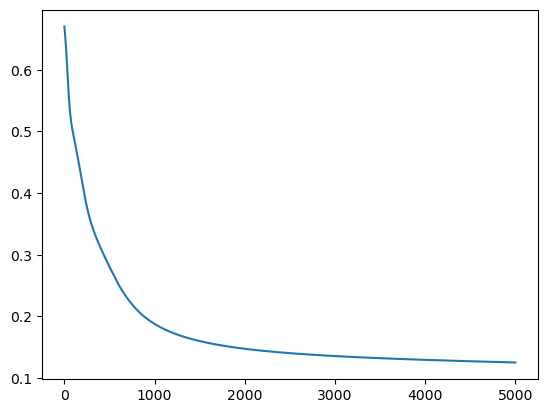

In [65]:
itr = [ i for i in range(5000)]
plt.plot(itr,costs)

In [69]:
def predict(X,paras):
    m = X.shape[1]
    n = len(paras) 
    p = np.zeros((1,m))
    AL,cache = L_Layer_forward(X , paras)
    for i in range(m):
        
        if AL[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    return p       

Y_hat_train = predict(X_train,paras)
Y_hat_test = predict(X_test,paras)

In [70]:
from sklearn.metrics import accuracy_score, classification_report

print("Model Report for Training Data : ")
print(classification_report(Y_train.T,Y_hat_train.T))

Model Report for Training Data : 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     14308
           1       0.98      0.96      0.97     35796

    accuracy                           0.95     50104
   macro avg       0.94      0.95      0.94     50104
weighted avg       0.95      0.95      0.95     50104



In [71]:

print("Model Report for Testing Data : ")
print(classification_report(Y_test.T,Y_hat_test.T))

Model Report for Testing Data : 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3565
           1       0.98      0.96      0.97      8961

    accuracy                           0.96     12526
   macro avg       0.94      0.95      0.95     12526
weighted avg       0.96      0.96      0.96     12526

